安裝必要套件

In [ ]:
! pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu118
! pip install immutabledict==4.1.0 sentencepiece==0.1.99 
! pip install kagglehub
! mkdir model

引入必要套件

In [1]:
import os, sys, torch, threading
import tkinter as tk
sys.path.append('gemma_pytorch')
from gemma_pytorch.gemma.config import get_config_for_2b
from gemma_pytorch.gemma.model import GemmaForCausalLM

檢查是否已將模型放入 'model' 資料夾

1. 到此連結下載: https://www.kaggle.com/models/google/gemma/pyTorch/1.1-2b-it

2. 選擇 2b-it 結尾的版本，前面數字越大版本越新 (需要登入 Kaggle 帳號才能下載)

3. 將檔案解壓縮並貼到 'model' 資料夾內

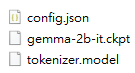

In [2]:
# Ensure that the tokenizer is present
tokenizer_path = os.path.join('model', 'tokenizer.model')
assert os.path.isfile(tokenizer_path), 'Tokenizer not found!'
# Ensure that the checkpoint is present
ckpt_path = os.path.join('model', 'gemma-2b-it.ckpt')
assert os.path.isfile(ckpt_path), 'PyTorch checkpoint not found!'

定義 PyTorch 的運算設備與使用模型

In [3]:
def define_device():
    torch_version = torch.__version__
    print(f"PyTorch version: {torch_version}", end=" -- ")

    # Check if MPS (Multi-Process Service) device is available on MacOS
    if torch.backends.mps.is_available():
        # If MPS is available, print a message indicating its usage
        print("using MPS device on MacOS")
        # Define the device as MPS
        defined_device = torch.device("mps")
    else:
        # If MPS is not available, determine the device based on GPU availability
        defined_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Print a message indicating the selected device
        print(f"using {defined_device}")

    return defined_device

def define_model():
    model_config = get_config_for_2b()
    model_config.tokenizer = tokenizer_path
    model_config.quant = False
    torch.set_default_dtype(model_config.get_dtype())
    define_model = GemmaForCausalLM(model_config)
    define_model.load_weights(ckpt_path)
    define_model = define_model.to(device).eval()
    return define_model

device = define_device()
model = define_model()

PyTorch version: 2.2.1+cu118 -- using cuda


定義對話模型的基本結構和功能

In [4]:
class GemmaAI:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.output_len = 20
        self.RECORD = []
        self.USER_CHAT_TEMPLATE = '<start_of_turn>user\n{prompt}<end_of_turn>\n'
        self.MODEL_CHAT_TEMPLATE = '<start_of_turn>model\n{prompt}<end_of_turn>\n'

    def generatePrompt(self):
        prompt = ''
        for i in range(len(self.RECORD)):
            prompt += self.USER_CHAT_TEMPLATE.format(prompt=self.RECORD[i]) if i % 2 == 0 else self.MODEL_CHAT_TEMPLATE.format(prompt=self.RECORD[i])
        prompt += '<start_of_turn>model\n'
        return prompt

    def generateReply(self):
        return self.model.generate(self.generatePrompt(), device=self.device, output_len=self.output_len)

    def generateTranslate(self, prompt, output_len):
        prompt = self.USER_CHAT_TEMPLATE.format(prompt=prompt) + '<start_of_turn>model\n'
        return self.model.generate(prompt, device=self.device, output_len=output_len)

    def user_last_text(self):
        return '' if len(self.RECORD) == 0 else self.RECORD[-2 + len(self.RECORD) % 2]

    def model_last_text(self):
        return '' if len(self.RECORD) < 1 or len(self.RECORD) % 2 != 0 else self.RECORD[-1]

    def updateOutputLen(self, val):
        self.output_len = int(val)

AI = GemmaAI(model, device)

建立 Tkinter 視窗

In [5]:
def create_main_widget():
    def disabled_button():
        infoBtn['state'] = 'disabled'
        sendBtn['state'] = 'disabled'
        aiBtn['state'] = 'disabled'
        chatBtn['state'] = 'disabled'
    def normal_button():
        infoBtn['state'] = 'normal'
        sendBtn['state'] = 'normal'
        aiBtn['state'] = 'normal'
        chatBtn['state'] = 'normal' if len(AI.RECORD) > 1 else 'disabled'
    def sendBtn_thread():
        reply = AI.generateReply()
        AI.RECORD.append(reply)
        text.delete(1.0, tk.END)
        text.insert(tk.END, reply)
        normal_button()
    def sendBtn_click():
        disabled_button()
        msg = entry.get()
        AI.RECORD = [msg]
        text.delete(1.0, tk.END)
        text.insert(tk.END, '~正在努力思考中~')
        thread = threading.Thread(target=sendBtn_thread)
        thread.start()
    def aiBtn_thread(prompt, output_len):
        translation = AI.generateTranslate(prompt, output_len)
        text.delete(1.0, tk.END)
        text.insert(tk.END, translation)
        normal_button()
    def aiBtn_click():
        disabled_button()
        prompt = '翻譯成繁中\n{}'.format(text.get(1.0, tk.END))
        output_len = len(prompt)*2
        text.delete(1.0, tk.END)
        if output_len > 0:
            text.insert(tk.END, '~正在努力翻譯中~')
            thread = threading.Thread(target=aiBtn_thread, args=(prompt, output_len))
            thread.start()
        else:
            text.insert(tk.END, '請在此處輸入需翻譯之內容')
    def chatBtn_thread():
        reply = AI.generateReply()
        AI.RECORD.append(reply)
        text.delete(1.0, tk.END)
        text.insert(tk.END, reply)
        normal_button()
    def chatBtn_click():
        disabled_button()
        msg = entry.get()
        AI.RECORD.append(msg)
        text.delete(1.0, tk.END)
        text.insert(tk.END, '~正在努力思考中~')
        thread = threading.Thread(target=chatBtn_thread)
        thread.start()
    
    for widget in root.winfo_children():
        widget.destroy()
    frame = tk.Frame(root)
    frame.grid(row=0, column=0, sticky='nsew')
    frame.grid_rowconfigure(1, weight=1)
    frame.grid_columnconfigure(0, weight=1)

    entryButtons = tk.Frame(frame)
    entryButtons.grid(row=0, column=0, sticky='ew')
    infoBtn = tk.Button(entryButtons, bitmap='info', command=lambda: create_info_widget())
    infoBtn.pack(side=tk.LEFT)
    entry = tk.Entry(entryButtons)
    entry.pack(side=tk.LEFT, fill='x', expand=1)
    sendBtn = tk.Button(entryButtons, text="送出", command=lambda: sendBtn_click())
    sendBtn.pack(side=tk.LEFT)

    text = tk.Text(frame)
    text.grid(row=1, column=0, sticky='nsew')

    buttons = tk.Frame(frame)
    buttons.grid(row=2, column=0, sticky='ew')
    aiBtn = tk.Button(buttons, text="智能翻譯", command=lambda: aiBtn_click())
    aiBtn.pack(side=tk.LEFT, fill='x', expand=1)
    chatBtn = tk.Button(buttons, text="繼續對話", command=lambda: chatBtn_click())
    chatBtn.pack(side=tk.LEFT, fill='x', expand=1)
    entry.insert(tk.END, AI.user_last_text())
    text.insert(tk.END, AI.model_last_text())
    normal_button()

def create_info_widget():
    for widget in root.winfo_children():
        widget.destroy()
    frame = tk.Frame(root)
    frame.pack()

    label1 = tk.Label(frame, text='使用 {} 進行運算\n'.format(str(device)))
    label1.pack()

    labels = tk.Frame(frame)
    labels.pack()
    label2 = tk.Label(labels, text='對話長度上限:')
    label2.pack(side=tk.LEFT)
    label3 = tk.Label(labels, textvariable=tk_output_len)
    label3.pack(side=tk.LEFT)

    scale_h = tk.Scale(frame, from_=20, to=2000, orient='horizontal', showvalue=False, variable=tk_output_len, command=AI.updateOutputLen)
    scale_h.pack()

    label4 = tk.Label(frame, text='上限越高輸出時間越長\n', font=('Arial',8), fg='#f00')
    label4.pack()

    backBtn = tk.Button(frame, text="返回", command=lambda: create_main_widget())
    backBtn.pack()

if __name__ == "__main__":
    # 創建主視窗
    root = tk.Tk()
    root.title('FloatChat')
    root.minsize(200, 160)
    root.attributes('-alpha', 0.8)

    # 獲取螢幕的寬度和高度
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()

    # 設定視窗的大小和位置
    root.geometry('200x160+{}+0'.format(screen_width - 200))

    # 讓視窗保持在最上層
    root.attributes('-topmost', True)

    root.grid_rowconfigure(0, weight=1)
    root.grid_columnconfigure(0, weight=1)

    tk_output_len = tk.IntVar()
    tk_output_len.set(AI.output_len)
    create_main_widget()

    # 開始主循環
    root.mainloop()